In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.linear_model import LinearRegression
import subprocess
import sys
import time

In [2]:
root_dir = "../.."
training_dir = f"{root_dir}/training"
checkpoint_dir = f"{training_dir}/checkpoints"
model_dir = f"{training_dir}/models"
evaluator_dir = f"{root_dir}/analysis/src/evaluation/model"
data_dir = f"{root_dir}/data"
analysis_dir = f"{data_dir}/analysis"

checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f != "latest.json"])
checkpoints = [json.loads(json.load(open(f"{checkpoint_dir}/{file}"))[1]) for file in checkpoint_files]

model_files = sorted([f for f in os.listdir(model_dir) if f != "latest.json"])

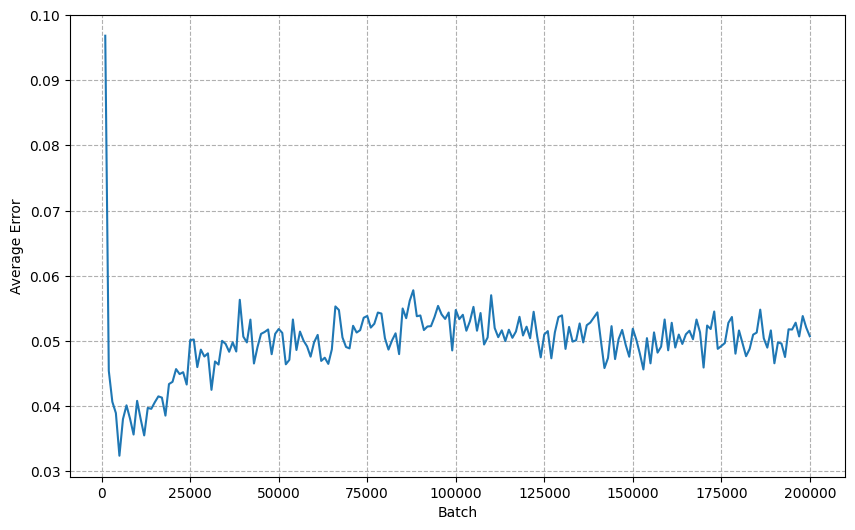

In [3]:
matplotlib.rc('figure', figsize=(10, 6))

batch = np.array([c["batch"] for c in checkpoints])
error = np.array([c["error"] for c in checkpoints])

ax = plt.gca()
ax.grid(True, which="both", linestyle="--")

plt.plot(batch, error)
plt.xlabel("Batch")
plt.ylabel("Average Error")
plt.show()

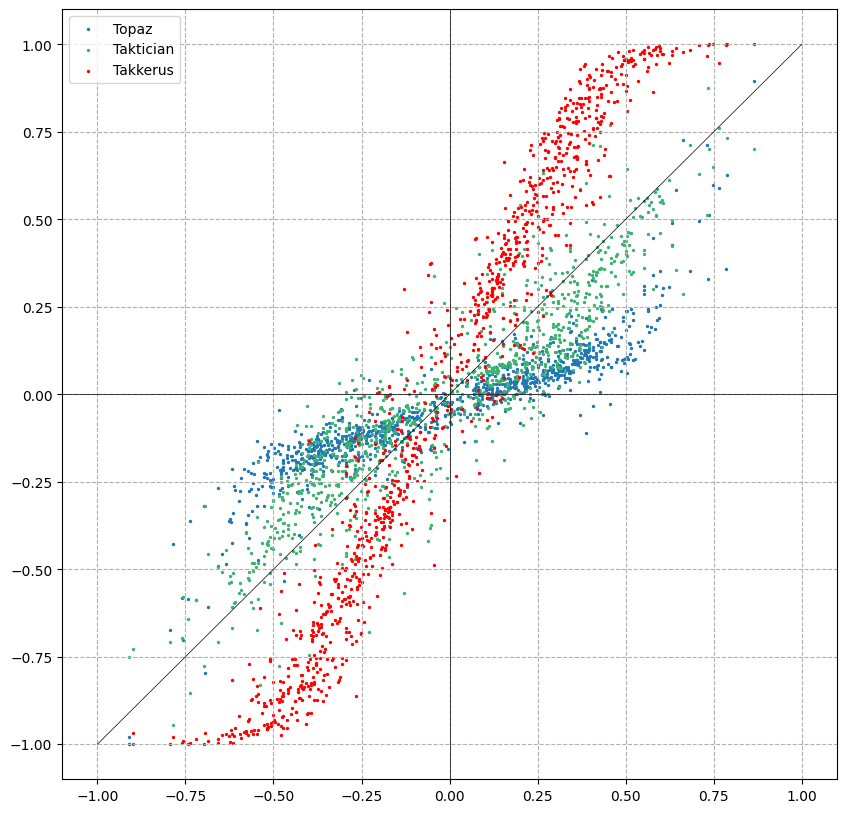

In [4]:
def normalized(x):
    return x / max(abs(x))

matplotlib.rc('figure', figsize=(10, 10))

subprocess.run(["cp", f"{model_dir}/latest.json", f"{evaluator_dir}/model_6s.json"])

takkerus = normalized(np.array(json.loads(subprocess.run(
    ["cargo", "run", "--bin", "evaluate_positions", "--features", "tools", "--", f"{data_dir}/comparison_set.json"],
    capture_output=True,
    text=True,
).stdout)))

topaz = normalized(np.array(json.load(open(f"{data_dir}/topaz_evaluations.json"))))
taktician = normalized(np.array(json.load(open(f"{data_dir}/taktician_evaluations.json"))))

baseline = (takkerus + topaz + taktician) / 3.0

ax = plt.gca()
ax.grid(True, which="both", linestyle="--")
ax.axhline(color="black", linewidth=0.5)
ax.axvline(color="black", linewidth=0.5)

plt.plot([-1.0, 1.0], [-1.0, 1.0], linestyle="-", linewidth=0.5, color="black")
plt.scatter(baseline, topaz, s=2, label="Topaz", color="#1f77b4")
plt.scatter(baseline, taktician, s=2, label="Taktician", color="mediumseagreen")
plt.scatter(baseline, takkerus, s=2, label="Takkerus", color="red")
plt.scatter
plt.legend(loc="upper left")
plt.show()

In [5]:
TOPAZ = "Topaz"
TAKTICIAN = "Taktician"
TAKKERUS = "Takkerus"

match_result = r"\+(\d+)-(\d+)=(\d+)"

def load_model(file):
    subprocess.run(["cp", f"{model_dir}/{file}", f"{evaluator_dir}/model_6s.json"])
    subprocess.run(["cargo", "build", "--release"], capture_output=True)

def play_match(opponent, games):
    engine_1 = "target/release/takkerus"
    engine_1_args = "tei --ai depth=4"

    if opponent == TOPAZ:
        engine_2 = "../topaz-tak/target/release/topaz"
        engine_2_args = ""
    elif opponent == TAKTICIAN:
        engine_2 = "../taktician/taktician"
        engine_2_args = "tei"
    elif opponent == TAKKERUS:
        engine_2 = engine_1
        engine_2_args = engine_1_args

    racetrack_dir = "../racetrack"

    p = subprocess.run([
        f"{racetrack_dir}/target/release/racetrack",
        "--engine", f"{engine_1}", f"{engine_2}",
        "--engine1-args", engine_1_args,
        "--engine2-args", engine_2_args,
        "--size", "6",
        "--komi", "0.0",
        "--concurrency", "4",
        "--games", str(games),
        "--tc", "600+20",
        "--book", f"{racetrack_dir}/6s_4ply_balanced_openings.txt",
        "--shuffle-book",
    ], capture_output=True, text=True)

    result = re.search(match_result, p.stdout.strip().split("\n")[-1])
    return result

def next_match(last_match):
    last_index = model_files.index(last_match)
    next_offset = 1 if "001000" in last_match else 2
    if last_index + next_offset >= len(model_files):
        return None
    else:
        return model_files[last_index + next_offset]

In [ ]:
if os.path.exists(f"{analysis_dir}/matches.json"):
    match_results = json.load(open(f"{analysis_dir}/matches.json"))
else:
    match_results = []

while len(match_results) == 0 or next_match(match_results[-1][0]) is not None:
    if len(match_results) == 0:
        next_model = model_files[0]
    else:
        next_model = next_match(match_results[-1][0])
        
    print(f"Beginning match: {next_model} vs {TOPAZ}")
    
    start = time.time()
    load_model(next_model)
    result = play_match(TOPAZ, 500)
    end = time.time()
    
    match_results.append([next_model, result.group(0)])
    print(f"  Match result: {result.group(0)}, {end - start:.2f}s")
    
    with open(f"{analysis_dir}/matches.json", "w") as f:
        f.write(json.dumps(match_results))

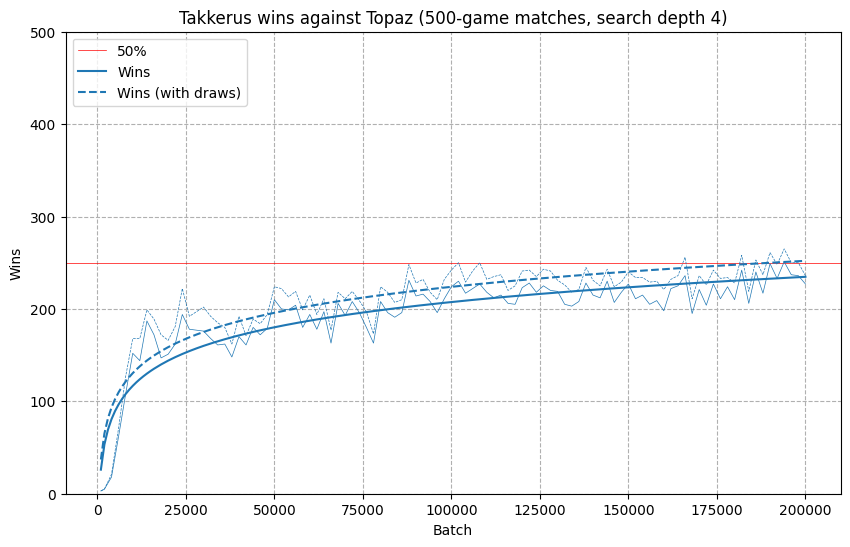

In [6]:
matplotlib.rc('figure', figsize=(10, 6))

files = [
    ("Wins", f"{analysis_dir}/matches.json", "#1f77b4"),
]

def load_matches(file):
    batches = [int(r[0][9:-5]) for r in json.load(open(file))]
    matches = [
        [int(m.group(1)), int(m.group(2)), int(m.group(3))]
        for m in [re.match(match_result, r[1]) for r in json.load(open(file))]
    ]
    return (batches, matches)

ax = plt.gca()
ax.set_ylim([0, 500])
ax.grid(True, which="both", linestyle="--")
ax.axhline(y=250, color="red", linewidth=0.5, label="50%")

curve_x = np.arange(1000, 200001, 1000)

for name, match_file, color in files:
    batches, matches = load_matches(match_file)
    x = np.log(np.array(batches).reshape(-1, 1))
    l = len(matches)
    wins = np.array([m[0] for m in matches])
    wins_and_draws = np.array([m[0] + m[2] for m in matches])

    regression = LinearRegression().fit(x[:l], wins)
    wins_curve = regression.predict(np.log(curve_x.reshape(-1, 1)))

    regression = LinearRegression().fit(x[:l], wins_and_draws)
    wins_and_draws_curve = regression.predict(np.log(curve_x.reshape(-1, 1)))
    
    plt.plot(batches, wins, color=color, linewidth=0.5)
    plt.plot(batches, wins_and_draws, linestyle="--", color=color, linewidth=0.5)
    plt.plot(curve_x, wins_curve, color=color, label=name)
    plt.plot(curve_x, wins_and_draws_curve, linestyle="--", color=color, label=f"{name} (with draws)")

plt.title("Takkerus wins against Topaz (500-game matches, search depth 4)")
plt.xlabel("Batch")
plt.ylabel("Wins")
plt.legend(loc="upper left")
plt.show()